<h1><strong>IMPORT</strong></h1>

In [1]:
import dask.dataframe as dd
from torch.utils.data import Dataset, DataLoader
from dask import delayed
from fastparquet import ParquetFile
import glob
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizerFast, AutoTokenizer
import random
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd

RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
# torch.use_deterministic_algorithms(True)

BATCH_SIZE = 128
MAX_SEQ_LEN = 128
VOCAB_SIZE = 30000
NUM_HEADS = 12
POS_ENC_LEN = MAX_SEQ_LEN
EMB_DIM = 768
FEED_FORWARD_DIM = EMB_DIM * 4
NUM_LAYERS = 12
DEVICE = "cuda"

/home/maxim/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


<h1><strong>PREPROCESS DATA/TOKENIZE</strong></h1>

In [2]:
class BertDataset(Dataset):
    def __init__(self, file_dict, max_seq_len, vocab_size):
        self.path = file_dict

        # Read files one by one
        files = glob.glob(file_dict)

        ddf = dd.from_delayed([self.load_chunk(f) for f in files])
        self.data = ddf.compute()

        # Load tokenizer
        self.max_seq_len = max_seq_len
        self.tokenizer = BertTokenizerFast.from_pretrained("tokenizer")
        bert_tokenizer = self.tokenizer.train_new_from_iterator(text_iterator=self.batch_iterator(), vocab_size=VOCAB_SIZE)
        bert_tokenizer.save_pretrained("tokenizer")
        self.tokenizer = bert_tokenizer

        self.vocab = self.tokenizer.get_vocab()
        self.pad_i = self.vocab['[PAD]']
        self.mask_i = self.vocab['[MASK]']

    @delayed
    def load_chunk(self, pth):
        x = ParquetFile(pth).to_pandas()
        return x

    def batch_iterator(self):
        for i in tqdm(range(0, len(self.data), self.max_seq_len)):
            yield self.data[i : i + self.max_seq_len ]["text"]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        text = self.data['text'][idx]

        # Encode the sentence
        sentence = []
        label_sentence = []
        encoding = self.tokenizer.encode(text, max_length = self.max_seq_len, return_special_tokens_mask=True, truncation=True)

        for token in encoding:
            prob = random.random()
            if prob < 0.15:
                prob /= 0.15
                if prob < 0.8:
                    sentence.append(self.mask_i)
                elif prob < 0.9:
                    sentence.append(random.randrange(len(self.vocab)))
                else:
                    sentence.append(token)

                label_sentence.append(token)
            else:
                sentence.append(token)
                label_sentence.append(0)

        padding = [self.pad_i for _ in range(self.max_seq_len - len(sentence))]
        sentence.extend(padding)
        label_sentence.extend(padding)

        sentence = torch.as_tensor(sentence)
        label_sentence = torch.as_tensor(label_sentence)

        return sentence, label_sentence

In [3]:
dataset = BertDataset('/media/maxim/DataSets/BERT/BERT-DATA/', vocab_size=VOCAB_SIZE, max_seq_len=MAX_SEQ_LEN)
tokenizer = dataset.tokenizer
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(tokenizer)

  9%|▉         | 5390/60969 [00:04<00:55, 1005.90it/s]

In [ ]:
print(len(dataset.vocab))

30000


In [ ]:
tokenizer.decode(next(iter(loader))[0][0])

'[CLS] [MASK] ` welcome, my dear [MASK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
next(iter(loader))[1][0]

tensor([  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 433,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

<h1><strong>EMBEDDINGS</strong></h1>

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len, device="cuda"):
        super().__init__()

        pe = torch.zeros(max_len, d_model, device=device).float()
        pe.require_grad = False

        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return self.pe

In [ ]:
class BertEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len, device="cuda", dropout=0.1):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len, device=device)
        self.dropout = nn.Dropout(p=dropout)
       
    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

<h1><strong>ATTENTION</strong></h1>

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()  
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)

        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e4)

        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        context = torch.matmul(weights, value)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        return self.output_linear(context)

<h1><strong>MODEL</strong></h1>

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim, dropout=0.1):
        super().__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, feed_forward_hidden, dropout=0.1):
        super().__init__()

        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)

        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [ ]:
class Bert(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, heads, feed_forward_dim, seq_len, device="cuda", dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        self.feed_forward_hidden = feed_forward_dim
        
        self.embedding = BertEmbedding(vocab_size=vocab_size, embed_size=d_model, seq_len=seq_len)

        self.encoder_blocks = nn.ModuleList(
            [EncoderLayer(d_model, heads, feed_forward_dim, dropout) for _ in range(n_layers)])

    def forward(self, x):
        mask = (x>0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1).to('cuda')

        x = self.embedding(x)

        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

<h1><strong>Language Model</strong></h1>

In [ ]:
class BertLM(nn.Module):
    def __init__(self, bert: Bert, emb_dim, vocab_size):
        super().__init__()
        self.bert = bert
        self.linear = torch.nn.Linear(emb_dim, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def save(self, step, epoch = None):
        now = datetime.now()

        dt_string = now.strftime("%d|%m|%Y %H:%M:%S")
        
        if epoch == None:
            torch.save(self, "saves/BERT_time: " + dt_string + "|step: " + step.__str__()  + ".pt")
        else:
            torch.save(self, "saves/BERT_time: " + dt_string + "|epoch: " + epoch.__str__()  + ".pt")

    def forward(self, x):
        x = self.bert(x)
        x = self.linear(x)
        out = self.softmax(x)
        return out

<h1><strong>TRAINING</strong></h1>

In [ ]:
class BertTrainer:
    def __init__(self, model, vocab, lr = 3e-5, weight_decay=0.01,
                betas=(0.9, 0.999), warmup_steps=10000, log_freq=10, device = "cuda"):
        self.device = device
        self.model = torch.compile(model.to(device))
        self.vocab = vocab

        self.scaler = torch.cuda.amp.GradScaler()

        self.optim = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

        # self.optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        # self.optim_schedule = ScheduledOptim(self.optim, EMB_DIM, n_warmup_steps=warmup_steps)

        self.criterion = torch.nn.NLLLoss(ignore_index=0)

        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, loader, epoch):
        self.iteration(epoch, loader)

    def test(self, loader, epoch, tokenizer):
        self.iteration(epoch, loader, tokenizer=tokenizer, train=False)

    def iteration(self, epoch, data_loader, tokenizer=None, train=True):
        loss_sum_epoch = 0
        loss_sum_steps = 0
        step = 0
        step_no_reset = 0
        loss_graph = []
        cola = 0

        if train:
            self.model.train()
        else:
            self.model.eval()

        # Iterate through dataloader
        for data, labels in tqdm(data_loader):

            data = data.to(self.device)
            labels = labels.to(self.device)

            # Convert data to 16 bit
            with torch.cuda.amp.autocast():
                mask_lm_output = self.model.forward(data)
                
            # Perform cross entropy loss
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), labels)
            loss = mask_loss
            loss_sum_steps += loss
            loss_sum_epoch += loss

            # Train the model and normalize (scale) the data scaler
            if train:
                self.optim.zero_grad()
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()

            # Create loss img and save the model
            if step_no_reset % 1000 == 0:
                temp = pd.DataFrame()
                temp['data'] = np.array(torch.as_tensor(loss_graph, device='cpu'))
                moving_average = temp['data'].rolling(window=5).mean()
                moving_average_large = temp['data'].rolling(window=20).mean()
                plt.plot(torch.as_tensor(loss_graph, device='cpu'), label="Original Data", color='black')
                plt.plot(torch.as_tensor(moving_average, device='cpu'), label="Scaled Data", color='pink')
                plt.plot(torch.as_tensor(moving_average_large, device='cpu'), label="Scaled Data_10", color='blue')
                plt.ylabel("loss")
                plt.savefig("saves/loss_" + str(step_no_reset) + ".png")
                
                self.model.save(step_no_reset)

                data_list = []
                for val in data[0]:
                    data_list.append(self.vocab[val.item()])
                print("Original Data: " + str(data_list))
                
                pred_list = []
                for vals in mask_lm_output[0]:
                    pred_list.append(self.vocab[vals.argmax().item()])
                print("Predicted Data: " + str(pred_list))
            
            # Save a loss checkpoint
            if step % 100 == 0:
                loss_sum_steps = 0
                step = 0
                loss_graph.append(loss)
                print(loss)
            step += 1
            step_no_reset += 1

        print(
            f"EP{epoch}, AVG LOSS{loss_sum_epoch / step_no_reset}"
        )
        
        self.model.save(0, epoch)

        temp = pd.DataFrame()
        temp['data'] = np.array(torch.as_tensor(loss_graph, device='cpu'))
        moving_average = temp['data'].rolling(window=5).mean()
        moving_average_large = temp['data'].rolling(window=20).mean()
        plt.plot(torch.as_tensor(loss_graph, device='cpu'), label="Original Data", color='black')
        plt.plot(torch.as_tensor(moving_average, device='cpu'), label="Scaled Data", color='pink')
        plt.plot(torch.as_tensor(moving_average_large, device='cpu'), label="Scaled Data_10", color='blue')
        plt.ylabel("loss")
        plt.savefig("saves/loss_" + str(step_no_reset) + ".png")

In [ ]:
vocab = dict((v,k) for k,v in tokenizer.get_vocab().items())

In [ ]:
# tensor(10.4820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   0%|          | 102/60969 [00:37<2:52:02,  5.90it/s]
# tensor(6.2316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   0%|          | 202/60969 [00:54<2:50:03,  5.96it/s]
# tensor(5.3472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   0%|          | 302/60969 [01:11<2:49:03,  5.98it/s]
# tensor(5.4243, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 402/60969 [01:27<2:47:53,  6.01it/s]
# tensor(5.0402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 502/60969 [01:44<2:49:59,  5.93it/s]
# tensor(4.3944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 602/60969 [02:00<2:49:33,  5.93it/s]
# tensor(4.5365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 702/60969 [02:17<2:48:36,  5.96it/s]
# tensor(4.7258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|▏         | 802/60969 [02:34<2:47:53,  5.97it/s]
# tensor(4.3716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|▏         | 902/60969 [02:50<2:51:01,  5.85it/s]
# tensor(4.9101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   2%|▏         | 1002/60969 [03:07<2:46:20,  6.01it/s]


#   0%|          | 1/60969 [00:37<637:22:38, 37.64s/it]
# Original Data: ['[CLS]', 'i', 'gave', 'up', 'steering', 'and', '[MASK]', 'the', '[MASK]', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
# Predicted Data: ['resp', 'philip', '##stock', 'resp', 'resp', 'dish', 'resp', 'daemonar', 'resp', 'chiff', 'sam', 'resp', 'resp', 'resp', 'pistol', 'resp', 'resp', 'jand', 'weighs', 'resp', 'resp', 'resp', 'weighs', '##tin', '##tin', 'resp', 'resp', 'vlad', 'resp', 'resp', 'bandage', 'jand', 'resp', 'foot', 'resp', 'langford', 'resp', 'sloane', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'cindere', 'resp', 'foot', 'resp', '##mouthed', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'langford', 'receded', 'resp', 'foot', 'foot', 'jand', 'resp', 'fabulous', 'resp', 'resp', 'resp', 'resp', 'resp', '##ened', 'simpson', 'resp', 'resp', 'resp', 'sugar', 'cindere', 'resp', 'resp', 'resp', 'resp', 'resp', 'rob', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'simpson', '##falls', 'resp', 'simpson', 'longest', 'resp', 'consequence', 'slithered', 'basket', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'resp', 'pharmaceutical', 'resp', 'resp', 'simpson', 'resp', 'shovel', 'resp', 'glorious', 'resp', 'resp', 'resp', 'resp', 'resp', 'fabulous', 'resp', 'mythical', 'glorious']
# tensor(10.4815, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   0%|          | 102/60969 [00:54<2:48:48,  6.01it/s]
# tensor(6.1861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   0%|          | 202/60969 [01:10<2:47:15,  6.06it/s]
# tensor(5.2391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   0%|          | 302/60969 [01:26<2:45:16,  6.12it/s]
# tensor(5.0080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 402/60969 [01:42<2:46:04,  6.08it/s]
# tensor(4.9924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 502/60969 [01:59<2:46:50,  6.04it/s]
# tensor(5.1263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 602/60969 [02:15<2:49:04,  5.95it/s]
# tensor(4.7006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|          | 702/60969 [02:32<2:46:37,  6.03it/s]
# tensor(4.9392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|▏         | 802/60969 [02:48<2:46:19,  6.03it/s]
# tensor(4.5711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   1%|▏         | 902/60969 [03:04<2:46:00,  6.03it/s]
# tensor(4.7683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
#   2%|▏         | 1002/60969 [03:21<2:47:45,  5.96it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Total Parameters: 131146032


  0%|          | 1/60969 [00:20<340:54:52, 20.13s/it]

Original Data: ['[CLS]', 'i', 'gave', 'up', 'steering', 'and', '[MASK]', 'the', '[MASK]', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

  0%|          | 102/60969 [00:36<2:45:50,  6.12it/s]

tensor(6.2325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 202/60969 [00:52<2:47:54,  6.03it/s]

tensor(5.3469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 302/60969 [01:08<2:44:16,  6.15it/s]

tensor(5.4258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 402/60969 [01:25<2:45:32,  6.10it/s]

tensor(5.0384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 502/60969 [01:41<2:44:22,  6.13it/s]

tensor(4.3940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 602/60969 [01:57<2:44:28,  6.12it/s]

tensor(4.5374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 702/60969 [02:14<2:45:45,  6.06it/s]

tensor(4.7250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 802/60969 [02:30<2:47:42,  5.98it/s]

tensor(4.3693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 902/60969 [02:46<2:46:59,  6.00it/s]

tensor(4.9092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 1002/60969 [03:03<2:44:51,  6.06it/s]

tensor(4.4962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 1102/60969 [03:19<2:46:13,  6.00it/s]

tensor(4.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 1202/60969 [03:36<2:47:22,  5.95it/s]

tensor(4.4111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 1302/60969 [03:52<2:46:26,  5.97it/s]

tensor(4.7081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 1402/60969 [04:08<2:42:46,  6.10it/s]

tensor(4.6840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 1502/60969 [04:25<2:43:55,  6.05it/s]

tensor(4.6075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 1602/60969 [04:41<2:45:53,  5.96it/s]

tensor(4.0558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 1702/60969 [04:58<2:45:34,  5.97it/s]

tensor(4.2996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 1802/60969 [05:14<2:41:31,  6.11it/s]

tensor(4.1884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 1902/60969 [05:30<2:42:23,  6.06it/s]

tensor(4.3165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 2002/60969 [05:47<2:42:06,  6.06it/s]

tensor(4.3752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 2102/60969 [06:03<2:45:16,  5.94it/s]

tensor(4.2138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 2202/60969 [06:19<2:42:05,  6.04it/s]

tensor(4.3738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 2302/60969 [06:35<2:39:16,  6.14it/s]

tensor(4.1383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 2402/60969 [06:52<2:40:32,  6.08it/s]

tensor(4.2380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 2502/60969 [07:08<2:38:30,  6.15it/s]

tensor(4.0901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 2602/60969 [07:24<2:39:55,  6.08it/s]

tensor(3.9953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 2702/60969 [07:40<2:41:34,  6.01it/s]

tensor(3.7191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 2802/60969 [07:57<2:41:01,  6.02it/s]

tensor(4.0883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 2902/60969 [08:13<2:40:32,  6.03it/s]

tensor(3.9547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 3002/60969 [08:30<2:41:58,  5.96it/s]

tensor(3.8117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 3102/60969 [08:46<2:41:01,  5.99it/s]

tensor(3.9190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 3202/60969 [09:03<2:40:27,  6.00it/s]

tensor(3.6805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 3302/60969 [09:19<2:43:50,  5.87it/s]

tensor(3.9178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 3402/60969 [09:36<2:39:48,  6.00it/s]

tensor(3.5840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 3502/60969 [09:52<2:40:58,  5.95it/s]

tensor(4.0122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 3602/60969 [10:09<2:38:42,  6.02it/s]

tensor(3.3661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 3702/60969 [10:25<2:40:59,  5.93it/s]

tensor(3.9456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 3802/60969 [10:42<2:39:13,  5.98it/s]

tensor(3.8780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 3902/60969 [10:58<2:41:29,  5.89it/s]

tensor(3.4624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 4002/60969 [11:15<2:41:00,  5.90it/s]

tensor(3.7221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 4102/60969 [11:32<2:36:49,  6.04it/s]

tensor(4.0065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 4202/60969 [11:48<2:36:08,  6.06it/s]

tensor(3.8412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 4302/60969 [12:04<2:34:16,  6.12it/s]

tensor(3.7365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 4402/60969 [12:20<2:30:21,  6.27it/s]

tensor(3.5348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 4502/60969 [12:36<2:34:30,  6.09it/s]

tensor(3.6955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 4602/60969 [12:53<2:36:00,  6.02it/s]

tensor(3.8367, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 4702/60969 [13:09<2:35:22,  6.04it/s]

tensor(3.6498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 4802/60969 [13:26<2:35:24,  6.02it/s]

tensor(3.6363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 4902/60969 [13:42<2:32:54,  6.11it/s]

tensor(3.6028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 5002/60969 [13:59<3:50:42,  4.04it/s]

Original Data: ['[CLS]', 'the', 'man', "'", 's', 'crazy', 'for', '[MASK]', 'and', '[MASK]', 'n', "'", 't', 'even', 'know', 'it', '[MASK]', "'", '[MASK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

  8%|▊         | 5102/60969 [14:15<2:33:29,  6.07it/s]

tensor(3.3012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 5202/60969 [14:32<2:36:08,  5.95it/s]

tensor(3.2469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 5302/60969 [14:48<2:31:16,  6.13it/s]

tensor(3.4570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 5402/60969 [15:04<2:32:21,  6.08it/s]

tensor(3.8779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 5502/60969 [15:21<2:31:25,  6.11it/s]

tensor(3.4690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 5602/60969 [15:37<2:37:35,  5.86it/s]

tensor(3.6094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 5702/60969 [15:54<2:32:40,  6.03it/s]

tensor(3.6708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 5802/60969 [16:10<2:29:34,  6.15it/s]

tensor(3.0988, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 5902/60969 [16:26<2:30:17,  6.11it/s]

tensor(3.9371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 6002/60969 [16:43<2:31:02,  6.07it/s]

tensor(3.7453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 6102/60969 [16:59<2:34:14,  5.93it/s]

tensor(3.8555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 6202/60969 [17:16<2:33:05,  5.96it/s]

tensor(3.6767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 6302/60969 [17:32<2:36:37,  5.82it/s]

tensor(3.6335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 6402/60969 [17:49<2:31:31,  6.00it/s]

tensor(3.0973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 6502/60969 [18:05<2:28:29,  6.11it/s]

tensor(3.2970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 6602/60969 [18:21<2:25:40,  6.22it/s]

tensor(3.2809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 6702/60969 [18:37<2:25:59,  6.20it/s]

tensor(3.4886, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 6802/60969 [18:54<2:26:22,  6.17it/s]

tensor(3.1881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 6902/60969 [19:10<2:34:46,  5.82it/s]

tensor(2.9781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 7002/60969 [19:27<2:28:17,  6.07it/s]

tensor(3.4052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 7102/60969 [19:43<2:29:14,  6.02it/s]

tensor(2.8666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 7202/60969 [20:00<2:32:01,  5.89it/s]

tensor(3.2981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 7302/60969 [20:16<2:28:19,  6.03it/s]

tensor(3.3461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 7402/60969 [20:33<2:28:02,  6.03it/s]

tensor(2.9969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 7502/60969 [20:49<2:27:45,  6.03it/s]

tensor(3.3054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 7602/60969 [21:05<2:26:54,  6.05it/s]

tensor(3.1157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 7702/60969 [21:22<2:30:16,  5.91it/s]

tensor(3.6502, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 7802/60969 [21:38<2:25:30,  6.09it/s]

tensor(3.4875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 7902/60969 [21:55<2:25:28,  6.08it/s]

tensor(3.4377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 8002/60969 [22:11<2:22:21,  6.20it/s]

tensor(3.4624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 8102/60969 [22:27<2:25:25,  6.06it/s]

tensor(3.2988, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 8202/60969 [22:43<2:22:07,  6.19it/s]

tensor(3.9248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 8302/60969 [22:59<2:20:04,  6.27it/s]

tensor(3.3135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 8402/60969 [23:16<2:28:03,  5.92it/s]

tensor(3.2477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 8502/60969 [23:32<2:28:12,  5.90it/s]

tensor(3.5660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 8602/60969 [23:49<2:25:49,  5.99it/s]

tensor(3.2714, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 8702/60969 [24:05<2:26:14,  5.96it/s]

tensor(2.8550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 8802/60969 [24:22<2:23:43,  6.05it/s]

tensor(3.4068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 8902/60969 [24:38<2:23:55,  6.03it/s]

tensor(3.1634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 9002/60969 [24:55<2:23:39,  6.03it/s]

tensor(3.3361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 9102/60969 [25:11<2:24:33,  5.98it/s]

tensor(3.6703, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 9202/60969 [25:28<2:24:57,  5.95it/s]

tensor(3.7035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 9302/60969 [25:44<2:24:33,  5.96it/s]

tensor(3.0634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 9402/60969 [26:01<2:26:20,  5.87it/s]

tensor(3.2065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 9502/60969 [26:18<2:26:24,  5.86it/s]

tensor(3.1437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 9602/60969 [26:34<2:23:56,  5.95it/s]

tensor(3.0722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 9702/60969 [26:51<2:27:06,  5.81it/s]

tensor(3.2757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 9802/60969 [27:08<2:22:23,  5.99it/s]

tensor(3.4055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 9902/60969 [27:24<2:23:11,  5.94it/s]

tensor(3.6338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 10002/60969 [27:41<3:36:42,  3.92it/s]

Original Data: ['[CLS]', 'now', ',', 'if', 'only', '[MASK]', 'had', '[MASK]', 'me', '.', '.', '.', 'what', 'the', 'hell', 'is', '[MASK]', 'on', '!', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

 17%|█▋        | 10102/60969 [27:58<2:23:29,  5.91it/s]

tensor(3.1393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 10202/60969 [28:15<2:25:23,  5.82it/s]

tensor(3.0961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 10302/60969 [28:31<2:22:31,  5.93it/s]

tensor(3.1115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 10402/60969 [28:48<2:22:24,  5.92it/s]

tensor(3.2903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 10502/60969 [29:04<2:24:00,  5.84it/s]

tensor(3.3976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 10602/60969 [29:21<2:20:25,  5.98it/s]

tensor(3.0456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 10702/60969 [29:37<2:21:27,  5.92it/s]

tensor(2.8646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 10802/60969 [29:54<2:24:14,  5.80it/s]

tensor(3.0542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 10902/60969 [30:11<2:24:16,  5.78it/s]

tensor(3.0756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 11002/60969 [30:28<2:23:26,  5.81it/s]

tensor(2.9562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 11102/60969 [30:44<2:22:22,  5.84it/s]

tensor(3.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 11202/60969 [31:01<2:21:28,  5.86it/s]

tensor(3.4016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 11302/60969 [31:18<2:19:30,  5.93it/s]

tensor(2.8461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 11402/60969 [31:35<2:21:59,  5.82it/s]

tensor(3.4810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 11502/60969 [31:51<2:20:20,  5.87it/s]

tensor(3.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 11602/60969 [32:08<2:21:06,  5.83it/s]

tensor(3.5726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 11702/60969 [32:25<2:20:12,  5.86it/s]

tensor(3.1669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 11802/60969 [32:41<2:17:31,  5.96it/s]

tensor(3.4906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 11902/60969 [32:58<2:16:15,  6.00it/s]

tensor(3.2617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 12002/60969 [33:15<2:14:58,  6.05it/s]

tensor(3.1482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 12102/60969 [33:31<2:17:36,  5.92it/s]

tensor(2.8743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 12202/60969 [33:48<2:15:27,  6.00it/s]

tensor(2.9972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 12302/60969 [34:04<2:16:27,  5.94it/s]

tensor(2.2837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 12402/60969 [34:21<2:17:09,  5.90it/s]

tensor(3.3143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 12502/60969 [34:37<2:16:04,  5.94it/s]

tensor(3.3858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 12602/60969 [34:54<2:14:26,  6.00it/s]

tensor(2.8276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 12702/60969 [35:10<2:15:35,  5.93it/s]

tensor(2.8480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 12802/60969 [35:27<2:13:30,  6.01it/s]

tensor(2.8755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 12902/60969 [35:43<2:15:33,  5.91it/s]

tensor(3.4681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 13002/60969 [36:00<2:15:01,  5.92it/s]

tensor(3.0107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 13102/60969 [36:16<2:11:23,  6.07it/s]

tensor(3.1373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 13202/60969 [36:33<2:13:13,  5.98it/s]

tensor(3.0854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 13302/60969 [36:49<2:12:35,  5.99it/s]

tensor(3.2119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 13402/60969 [37:06<2:11:24,  6.03it/s]

tensor(3.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 13502/60969 [37:22<2:11:49,  6.00it/s]

tensor(3.3313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 13602/60969 [37:39<2:10:57,  6.03it/s]

tensor(3.2647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 13702/60969 [37:55<2:10:26,  6.04it/s]

tensor(2.8779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 13802/60969 [38:12<2:09:52,  6.05it/s]

tensor(3.3920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 13902/60969 [38:29<2:11:01,  5.99it/s]

tensor(3.3981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 14002/60969 [38:45<2:10:37,  5.99it/s]

tensor(2.8989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 14102/60969 [39:01<2:11:11,  5.95it/s]

tensor(2.9776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 14202/60969 [39:18<2:09:53,  6.00it/s]

tensor(3.0395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 14302/60969 [39:35<2:12:54,  5.85it/s]

tensor(3.0999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 14402/60969 [39:51<2:11:46,  5.89it/s]

tensor(3.2438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 14502/60969 [40:08<2:09:51,  5.96it/s]

tensor(3.5165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 14602/60969 [40:24<2:10:11,  5.94it/s]

tensor(3.4792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 14702/60969 [40:41<2:09:53,  5.94it/s]

tensor(3.2958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 14802/60969 [40:58<2:09:15,  5.95it/s]

tensor(2.9241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 14902/60969 [41:14<2:07:54,  6.00it/s]

tensor(3.0898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 15002/60969 [41:31<3:13:00,  3.97it/s]

Original Data: ['[CLS]', '`', '`', 'it', 'looks', 'incredible', '[MASK]', "'", "'", 'he', 'said', '.', '[MASK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

 25%|██▍       | 15102/60969 [41:48<2:08:45,  5.94it/s]

tensor(2.7058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 15202/60969 [42:05<2:08:22,  5.94it/s]

tensor(3.2960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 15302/60969 [42:21<2:06:18,  6.03it/s]

tensor(2.5926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 15402/60969 [42:38<2:08:13,  5.92it/s]

tensor(2.8025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 15502/60969 [42:54<2:06:36,  5.99it/s]

tensor(2.5714, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 15602/60969 [43:11<2:07:03,  5.95it/s]

tensor(3.1635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 15702/60969 [43:27<2:05:12,  6.03it/s]

tensor(2.6845, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 15802/60969 [43:44<2:05:45,  5.99it/s]

tensor(3.4080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 15902/60969 [44:00<2:05:08,  6.00it/s]

tensor(3.0290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 16002/60969 [44:17<2:04:03,  6.04it/s]

tensor(2.7094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 16102/60969 [44:33<2:03:24,  6.06it/s]

tensor(3.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 16202/60969 [44:49<2:03:05,  6.06it/s]

tensor(2.7658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 16302/60969 [45:06<2:02:57,  6.05it/s]

tensor(2.8706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 16402/60969 [45:22<2:03:09,  6.03it/s]

tensor(2.5468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 16502/60969 [45:39<2:03:20,  6.01it/s]

tensor(3.1379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 16602/60969 [45:55<2:04:28,  5.94it/s]

tensor(2.9218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 16702/60969 [46:11<2:02:58,  6.00it/s]

tensor(2.8965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 16802/60969 [46:28<2:01:58,  6.04it/s]

tensor(2.8481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 16902/60969 [46:44<2:02:32,  5.99it/s]

tensor(3.0901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 17002/60969 [47:00<2:03:51,  5.92it/s]

tensor(2.6328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 17102/60969 [47:17<2:03:09,  5.94it/s]

tensor(2.8529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 17202/60969 [47:34<1:59:32,  6.10it/s]

tensor(2.6260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 17302/60969 [47:50<2:01:04,  6.01it/s]

tensor(2.7049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 17402/60969 [48:07<2:04:54,  5.81it/s]

tensor(2.6222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 17502/60969 [48:23<2:01:06,  5.98it/s]

tensor(2.8517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 17602/60969 [48:40<2:02:25,  5.90it/s]

tensor(2.7314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 17702/60969 [48:56<2:00:05,  6.00it/s]

tensor(2.8322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 17802/60969 [49:13<2:01:18,  5.93it/s]

tensor(2.9866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 17902/60969 [49:30<1:59:29,  6.01it/s]

tensor(2.9599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 18002/60969 [49:46<1:58:59,  6.02it/s]

tensor(2.7049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 18102/60969 [50:03<1:58:38,  6.02it/s]

tensor(3.1298, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 18202/60969 [50:19<1:58:26,  6.02it/s]

tensor(3.0515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 18302/60969 [50:36<1:58:13,  6.02it/s]

tensor(3.0698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 18402/60969 [50:53<1:57:22,  6.04it/s]

tensor(2.6123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 18502/60969 [51:09<2:01:05,  5.85it/s]

tensor(3.1220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 18602/60969 [51:26<1:56:53,  6.04it/s]

tensor(3.1239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 18702/60969 [51:42<1:59:18,  5.90it/s]

tensor(2.5754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 18802/60969 [51:59<1:57:02,  6.00it/s]

tensor(2.7843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 18902/60969 [52:15<1:59:02,  5.89it/s]

tensor(2.8630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 19002/60969 [52:32<1:56:45,  5.99it/s]

tensor(2.9698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 19102/60969 [52:48<1:55:41,  6.03it/s]

tensor(2.2197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 19202/60969 [53:05<1:57:06,  5.94it/s]

tensor(3.2909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 19302/60969 [53:21<1:58:20,  5.87it/s]

tensor(2.8467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 19402/60969 [53:38<1:55:36,  5.99it/s]

tensor(2.5628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 19502/60969 [53:54<1:55:49,  5.97it/s]

tensor(2.5456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 19602/60969 [54:11<1:56:38,  5.91it/s]

tensor(2.9472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 19702/60969 [54:27<1:54:38,  6.00it/s]

tensor(2.7293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 19802/60969 [54:44<1:54:17,  6.00it/s]

tensor(2.8555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 19902/60969 [55:00<1:55:54,  5.91it/s]

tensor(3.3048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 20002/60969 [55:17<2:50:07,  4.01it/s]

Original Data: ['[CLS]', 'not', 'because', 'she', '[MASK]', 'doing', 'it', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

 33%|███▎      | 20102/60969 [55:33<1:53:02,  6.02it/s]

tensor(2.8413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 20202/60969 [55:50<1:53:55,  5.96it/s]

tensor(2.8185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 20302/60969 [56:06<1:53:16,  5.98it/s]

tensor(2.7734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 20402/60969 [56:23<1:51:50,  6.04it/s]

tensor(3.0732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 20502/60969 [56:39<1:52:09,  6.01it/s]

tensor(3.1875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 20602/60969 [56:56<1:53:35,  5.92it/s]

tensor(2.8524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 20702/60969 [57:12<1:50:53,  6.05it/s]

tensor(2.5024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 20802/60969 [57:29<1:53:16,  5.91it/s]

tensor(2.5240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 20902/60969 [57:45<1:51:49,  5.97it/s]

tensor(2.7327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 21002/60969 [58:02<1:51:11,  5.99it/s]

tensor(2.7251, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 21102/60969 [58:18<1:52:02,  5.93it/s]

tensor(2.4698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 21202/60969 [58:35<1:50:48,  5.98it/s]

tensor(3.1485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 21302/60969 [58:51<1:50:06,  6.00it/s]

tensor(3.0519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 21402/60969 [59:08<1:50:39,  5.96it/s]

tensor(3.1092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 21502/60969 [59:24<1:51:04,  5.92it/s]

tensor(2.5594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 21602/60969 [59:41<1:48:38,  6.04it/s]

tensor(2.7759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 21702/60969 [59:58<1:49:32,  5.97it/s]

tensor(3.0143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 21802/60969 [1:00:14<1:49:32,  5.96it/s]

tensor(2.7855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 21902/60969 [1:00:31<1:49:34,  5.94it/s]

tensor(2.5080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 22002/60969 [1:00:48<1:47:38,  6.03it/s]

tensor(3.0174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 22102/60969 [1:01:04<1:47:53,  6.00it/s]

tensor(2.6300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 22202/60969 [1:01:21<1:47:10,  6.03it/s]

tensor(2.3089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 22302/60969 [1:01:37<1:47:25,  6.00it/s]

tensor(2.8461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 22402/60969 [1:01:54<1:47:36,  5.97it/s]

tensor(2.9021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 22502/60969 [1:02:11<1:49:26,  5.86it/s]

tensor(2.6750, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 22602/60969 [1:02:27<1:48:46,  5.88it/s]

tensor(2.9940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 22702/60969 [1:02:44<1:45:55,  6.02it/s]

tensor(2.8882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 22802/60969 [1:03:00<2:02:30,  5.19it/s]

tensor(2.6033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 22902/60969 [1:03:17<1:45:17,  6.03it/s]

tensor(3.0104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 23002/60969 [1:03:33<1:45:53,  5.98it/s]

tensor(2.8552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 23102/60969 [1:03:49<1:43:52,  6.08it/s]

tensor(2.6929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 23202/60969 [1:04:05<1:41:02,  6.23it/s]

tensor(2.6826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 23302/60969 [1:04:21<1:42:09,  6.14it/s]

tensor(2.4312, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 23402/60969 [1:04:37<1:39:54,  6.27it/s]

tensor(3.1245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 23502/60969 [1:04:53<1:44:29,  5.98it/s]

tensor(2.6688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 23602/60969 [1:05:09<1:46:02,  5.87it/s]

tensor(2.6579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 23702/60969 [1:05:25<1:39:23,  6.25it/s]

tensor(2.7246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 23802/60969 [1:05:41<1:42:58,  6.02it/s]

tensor(2.9386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 23902/60969 [1:05:58<1:42:56,  6.00it/s]

tensor(2.7774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 24002/60969 [1:06:15<1:42:02,  6.04it/s]

tensor(2.4826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 24102/60969 [1:06:31<1:41:52,  6.03it/s]

tensor(2.8908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 24202/60969 [1:06:47<1:41:25,  6.04it/s]

tensor(2.4908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 24302/60969 [1:07:04<1:41:54,  6.00it/s]

tensor(2.9449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 24402/60969 [1:07:20<1:40:56,  6.04it/s]

tensor(2.7963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 24502/60969 [1:07:37<1:40:49,  6.03it/s]

tensor(2.8294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 24602/60969 [1:07:53<1:40:09,  6.05it/s]

tensor(2.3691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 24702/60969 [1:08:09<1:39:56,  6.05it/s]

tensor(2.6857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 24802/60969 [1:08:26<1:39:38,  6.05it/s]

tensor(2.7794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 24902/60969 [1:08:42<1:39:29,  6.04it/s]

tensor(2.9651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 25002/60969 [1:08:59<2:28:58,  4.02it/s]

Original Data: ['[CLS]', 'still', ',', '[MASK]', 'devotion', 'to', 'my', 'grandma', 'and', 'me', 'too', 'touched', 'me', 'more', 'than', '[MASK]', 'he', '[MASK]', 'd', 'ever', '[MASK]', 'or', 'done', 'before', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

 41%|████      | 25102/60969 [1:09:15<1:38:57,  6.04it/s]

tensor(2.5547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 25202/60969 [1:09:32<1:38:37,  6.04it/s]

tensor(2.6220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 25302/60969 [1:09:48<1:38:41,  6.02it/s]

tensor(2.8059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 25402/60969 [1:10:05<1:39:14,  5.97it/s]

tensor(2.8715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 25502/60969 [1:10:21<1:39:28,  5.94it/s]

tensor(2.6899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 25602/60969 [1:10:37<1:38:34,  5.98it/s]

tensor(2.7437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 25702/60969 [1:10:54<1:38:23,  5.97it/s]

tensor(2.6538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 25802/60969 [1:11:10<1:36:52,  6.05it/s]

tensor(2.5390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 25902/60969 [1:11:27<1:36:52,  6.03it/s]

tensor(2.7253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 26002/60969 [1:11:43<1:36:32,  6.04it/s]

tensor(3.1437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 26102/60969 [1:12:00<1:36:12,  6.04it/s]

tensor(2.7021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 26202/60969 [1:12:16<1:35:31,  6.07it/s]

tensor(2.8311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 26302/60969 [1:12:32<1:35:23,  6.06it/s]

tensor(2.8876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 26402/60969 [1:12:49<1:35:11,  6.05it/s]

tensor(3.0280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 26502/60969 [1:13:05<1:34:56,  6.05it/s]

tensor(2.2865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 26602/60969 [1:13:22<1:34:16,  6.08it/s]

tensor(2.4628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 26702/60969 [1:13:38<1:34:16,  6.06it/s]

tensor(2.6733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 26802/60969 [1:13:54<1:34:18,  6.04it/s]

tensor(2.7485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 26902/60969 [1:14:11<1:34:29,  6.01it/s]

tensor(2.5837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 27002/60969 [1:14:27<1:34:09,  6.01it/s]

tensor(2.9307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 27102/60969 [1:14:43<1:33:26,  6.04it/s]

tensor(2.9397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 27202/60969 [1:15:00<1:33:26,  6.02it/s]

tensor(2.9982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 27302/60969 [1:15:16<1:32:52,  6.04it/s]

tensor(2.5931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 27402/60969 [1:15:32<1:31:48,  6.09it/s]

tensor(2.7766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 27502/60969 [1:15:48<1:31:21,  6.11it/s]

tensor(2.5994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 27602/60969 [1:16:05<1:31:12,  6.10it/s]

tensor(2.6651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 27702/60969 [1:16:21<1:30:46,  6.11it/s]

tensor(2.7142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 27802/60969 [1:16:37<1:30:52,  6.08it/s]

tensor(2.8631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 27902/60969 [1:16:54<1:31:17,  6.04it/s]

tensor(2.5057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 28002/60969 [1:17:10<1:31:00,  6.04it/s]

tensor(2.7504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 28102/60969 [1:17:26<1:30:45,  6.04it/s]

tensor(2.6153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 28202/60969 [1:17:42<1:30:43,  6.02it/s]

tensor(2.4982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 28302/60969 [1:17:59<1:29:06,  6.11it/s]

tensor(2.6241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 28402/60969 [1:18:15<1:28:58,  6.10it/s]

tensor(2.4684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 28502/60969 [1:18:31<1:28:42,  6.10it/s]

tensor(2.7430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 28602/60969 [1:18:47<1:29:19,  6.04it/s]

tensor(2.2901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 28702/60969 [1:19:04<1:28:20,  6.09it/s]

tensor(2.7743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 28802/60969 [1:19:20<1:28:09,  6.08it/s]

tensor(2.9038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 28902/60969 [1:19:36<1:29:23,  5.98it/s]

tensor(2.1125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 29002/60969 [1:19:53<1:27:46,  6.07it/s]

tensor(3.0089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 29102/60969 [1:20:09<1:28:01,  6.03it/s]

tensor(3.0246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 29202/60969 [1:20:26<1:28:02,  6.01it/s]

tensor(2.7178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 29302/60969 [1:20:42<1:27:47,  6.01it/s]

tensor(2.5662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 29402/60969 [1:20:58<1:19:37,  6.61it/s]

tensor(2.7559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 29502/60969 [1:21:13<1:19:24,  6.60it/s]

tensor(2.9529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 29602/60969 [1:21:27<1:19:10,  6.60it/s]

tensor(2.5573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 29702/60969 [1:21:42<1:19:00,  6.60it/s]

tensor(2.6595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 29802/60969 [1:21:57<1:18:37,  6.61it/s]

tensor(2.8686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 29902/60969 [1:22:12<1:18:34,  6.59it/s]

tensor(2.5557, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 30002/60969 [1:22:28<2:00:15,  4.29it/s]

Original Data: ['[MASK]', 'my', 'arms', 'wrapped', 'around', 'colt', '[MASK]', '[MASK]', 'neck', 'and', 'he', 'held', '[MASK]', 'as', 'his', 'strong', 'arms', 'carried', 'me', 'to', '[MASK]', '[MASK]', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

 49%|████▉     | 30102/60969 [1:22:43<1:18:09,  6.58it/s]

tensor(2.7612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 30202/60969 [1:22:58<1:17:44,  6.60it/s]

tensor(2.3257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 30302/60969 [1:23:13<1:17:21,  6.61it/s]

tensor(2.4878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 30402/60969 [1:23:27<1:17:13,  6.60it/s]

tensor(2.5508, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 30502/60969 [1:23:42<1:16:53,  6.60it/s]

tensor(2.5401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 30602/60969 [1:23:57<1:16:43,  6.60it/s]

tensor(2.6716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 30702/60969 [1:24:12<1:16:23,  6.60it/s]

tensor(2.8192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 30802/60969 [1:24:27<1:16:08,  6.60it/s]

tensor(2.8831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 30902/60969 [1:24:42<1:15:49,  6.61it/s]

tensor(2.9786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 31002/60969 [1:24:57<1:15:44,  6.59it/s]

tensor(2.5472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 31102/60969 [1:25:12<1:15:35,  6.59it/s]

tensor(2.9314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 31202/60969 [1:25:27<1:15:11,  6.60it/s]

tensor(2.6329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 31302/60969 [1:25:42<1:14:55,  6.60it/s]

tensor(2.5513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 31402/60969 [1:25:57<1:14:39,  6.60it/s]

tensor(2.7322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 31502/60969 [1:26:12<1:14:33,  6.59it/s]

tensor(2.8315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 31602/60969 [1:26:27<1:14:20,  6.58it/s]

tensor(2.6751, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 31702/60969 [1:26:43<1:20:56,  6.03it/s]

tensor(2.5870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 31802/60969 [1:26:59<1:18:33,  6.19it/s]

tensor(2.7082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 31902/60969 [1:27:15<1:20:40,  6.01it/s]

tensor(2.4492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 32002/60969 [1:27:32<1:20:37,  5.99it/s]

tensor(2.5935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 32102/60969 [1:27:48<1:20:21,  5.99it/s]

tensor(2.5914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 32202/60969 [1:28:05<1:20:25,  5.96it/s]

tensor(2.7447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 32302/60969 [1:28:21<1:19:55,  5.98it/s]

tensor(2.8805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 32402/60969 [1:28:38<1:20:58,  5.88it/s]

tensor(2.4185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 32502/60969 [1:28:54<1:19:46,  5.95it/s]

tensor(2.7470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 32602/60969 [1:29:11<1:19:24,  5.95it/s]

tensor(2.2023, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 32702/60969 [1:29:27<1:18:40,  5.99it/s]

tensor(2.6520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 32802/60969 [1:29:44<1:20:12,  5.85it/s]

tensor(2.3674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 32902/60969 [1:30:01<1:19:12,  5.91it/s]

tensor(3.0267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 33002/60969 [1:30:17<1:19:19,  5.88it/s]

tensor(2.5880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 33102/60969 [1:30:34<1:18:14,  5.94it/s]

tensor(2.7492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 33202/60969 [1:30:51<1:18:45,  5.88it/s]

tensor(2.5994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 33302/60969 [1:31:07<1:19:07,  5.83it/s]

tensor(2.8722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 33402/60969 [1:31:24<1:17:50,  5.90it/s]

tensor(2.6567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 33502/60969 [1:31:41<1:15:58,  6.03it/s]

tensor(2.4701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 33602/60969 [1:31:57<1:15:53,  6.01it/s]

tensor(2.6742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 33702/60969 [1:32:14<1:15:44,  6.00it/s]

tensor(2.7141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 33802/60969 [1:32:31<1:18:07,  5.80it/s]

tensor(2.9662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 33902/60969 [1:32:48<1:16:06,  5.93it/s]

tensor(2.7590, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 34002/60969 [1:33:04<1:14:22,  6.04it/s]

tensor(2.7811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 34102/60969 [1:33:21<1:16:21,  5.86it/s]

tensor(2.6860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 34202/60969 [1:33:37<1:15:41,  5.89it/s]

tensor(2.5266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 34302/60969 [1:33:54<1:15:10,  5.91it/s]

tensor(2.8654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 34402/60969 [1:34:11<1:14:43,  5.92it/s]

tensor(2.8085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 34502/60969 [1:34:28<1:14:29,  5.92it/s]

tensor(2.5035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 34602/60969 [1:34:44<1:13:53,  5.95it/s]

tensor(2.4764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 34702/60969 [1:35:01<1:14:06,  5.91it/s]

tensor(2.5254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 34802/60969 [1:35:17<1:13:36,  5.92it/s]

tensor(2.3878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 34902/60969 [1:35:34<1:12:33,  5.99it/s]

tensor(2.5310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 35002/60969 [1:35:51<1:51:40,  3.88it/s]

Original Data: ['[CLS]', 'love', 'you', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

 58%|█████▊    | 35102/60969 [1:36:08<1:12:28,  5.95it/s]

tensor(2.7178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 35202/60969 [1:36:24<1:10:55,  6.06it/s]

tensor(2.4863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 35302/60969 [1:36:41<1:10:41,  6.05it/s]

tensor(2.6223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 35402/60969 [1:36:57<1:10:52,  6.01it/s]

tensor(2.8507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 35502/60969 [1:37:13<1:09:44,  6.09it/s]

tensor(2.6252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 35602/60969 [1:37:30<1:10:17,  6.02it/s]

tensor(2.5288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 35702/60969 [1:37:46<1:09:42,  6.04it/s]

tensor(2.5964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 35802/60969 [1:38:03<1:10:45,  5.93it/s]

tensor(2.7679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 35902/60969 [1:38:19<1:09:33,  6.01it/s]

tensor(2.6001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 36002/60969 [1:38:36<1:10:16,  5.92it/s]

tensor(2.8492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 36102/60969 [1:38:52<1:08:43,  6.03it/s]

tensor(2.6538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 36202/60969 [1:39:09<1:08:58,  5.98it/s]

tensor(2.6397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 36302/60969 [1:39:25<1:09:20,  5.93it/s]

tensor(2.8149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 36402/60969 [1:39:42<1:09:27,  5.89it/s]

tensor(2.4243, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 36502/60969 [1:39:59<1:08:41,  5.94it/s]

tensor(2.3195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 36602/60969 [1:40:15<1:07:14,  6.04it/s]

tensor(2.5954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 36702/60969 [1:40:32<1:07:34,  5.99it/s]

tensor(2.6647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 36802/60969 [1:40:48<1:06:30,  6.06it/s]

tensor(2.4897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 36902/60969 [1:41:05<1:08:44,  5.84it/s]

tensor(2.7115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 37002/60969 [1:41:22<1:06:51,  5.97it/s]

tensor(2.4004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 37102/60969 [1:41:38<1:07:39,  5.88it/s]

tensor(2.4327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 37202/60969 [1:41:55<1:07:43,  5.85it/s]

tensor(2.5311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 37302/60969 [1:42:12<1:06:09,  5.96it/s]

tensor(2.3810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 37402/60969 [1:42:28<1:05:08,  6.03it/s]

tensor(2.5123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 37502/60969 [1:42:45<1:06:35,  5.87it/s]

tensor(2.3222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 37602/60969 [1:43:02<1:06:19,  5.87it/s]

tensor(2.8102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 37702/60969 [1:43:18<1:05:10,  5.95it/s]

tensor(2.5350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 37802/60969 [1:43:35<1:04:04,  6.03it/s]

tensor(2.7799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 37902/60969 [1:43:52<1:06:18,  5.80it/s]

tensor(2.6104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 38002/60969 [1:44:09<1:05:18,  5.86it/s]

tensor(2.7205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 38102/60969 [1:44:25<1:03:41,  5.98it/s]

tensor(2.3211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 38202/60969 [1:44:42<1:04:04,  5.92it/s]

tensor(2.6107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 38302/60969 [1:44:59<1:04:43,  5.84it/s]

tensor(2.7630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 38402/60969 [1:45:16<1:04:32,  5.83it/s]

tensor(2.6710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 38502/60969 [1:45:32<1:03:14,  5.92it/s]

tensor(2.9770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 38602/60969 [1:45:49<1:02:27,  5.97it/s]

tensor(2.5606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 38702/60969 [1:46:06<1:03:24,  5.85it/s]

tensor(2.6978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 38802/60969 [1:46:22<1:03:13,  5.84it/s]

tensor(2.6086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 38902/60969 [1:46:39<1:02:28,  5.89it/s]

tensor(2.5982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 39002/60969 [1:46:56<1:02:05,  5.90it/s]

tensor(2.5011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 39102/60969 [1:47:12<1:01:19,  5.94it/s]

tensor(2.5801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 39202/60969 [1:47:29<1:01:37,  5.89it/s]

tensor(2.5138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 39302/60969 [1:47:46<1:01:02,  5.92it/s]

tensor(2.1771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 39402/60969 [1:48:02<1:00:38,  5.93it/s]

tensor(2.7328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 39502/60969 [1:48:19<1:00:36,  5.90it/s]

tensor(2.0855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 39602/60969 [1:48:35<59:37,  5.97it/s]  

tensor(2.3319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 39702/60969 [1:48:52<59:19,  5.97it/s]

tensor(2.6565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 39802/60969 [1:49:08<59:28,  5.93it/s]

tensor(2.4124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 39902/60969 [1:49:25<58:23,  6.01it/s]

tensor(2.5101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 40002/60969 [1:49:42<1:29:56,  3.89it/s]

Original Data: ['[CLS]', 'i', '[MASK]', 'it', 'was', 'a', 'great', 'idea', ',', 'because', 'they', 'could', '[MASK]', '[MASK]', '[MASK]', 'it', '.', '[MASK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

 66%|██████▌   | 40102/60969 [1:49:59<58:13,  5.97it/s]  

tensor(2.9009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 40202/60969 [1:50:15<57:30,  6.02it/s]

tensor(2.6736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 40302/60969 [1:50:31<58:07,  5.93it/s]

tensor(2.3255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 40402/60969 [1:50:48<56:59,  6.01it/s]

tensor(2.6461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 40502/60969 [1:51:05<57:40,  5.91it/s]

tensor(2.1457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 40602/60969 [1:51:21<53:46,  6.31it/s]

tensor(2.1468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 40702/60969 [1:51:36<52:53,  6.39it/s]

tensor(2.5825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 40802/60969 [1:51:52<53:47,  6.25it/s]

tensor(2.6807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 40902/60969 [1:52:08<55:19,  6.05it/s]

tensor(2.6802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 41002/60969 [1:52:24<52:35,  6.33it/s]

tensor(2.7973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 41102/60969 [1:52:39<54:32,  6.07it/s]

tensor(2.9157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 41202/60969 [1:52:55<53:39,  6.14it/s]

tensor(2.1779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 41302/60969 [1:53:11<52:56,  6.19it/s]

tensor(2.7559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 41402/60969 [1:53:27<49:29,  6.59it/s]

tensor(2.3422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 41502/60969 [1:53:42<50:29,  6.43it/s]

tensor(2.8113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 41602/60969 [1:53:58<50:07,  6.44it/s]

tensor(2.9864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 41702/60969 [1:54:13<49:23,  6.50it/s]

tensor(2.3779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 41802/60969 [1:54:28<48:26,  6.60it/s]

tensor(2.4414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 41902/60969 [1:54:44<48:42,  6.52it/s]

tensor(2.6059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 42002/60969 [1:54:59<48:09,  6.56it/s]

tensor(2.5070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 42102/60969 [1:55:15<48:13,  6.52it/s]

tensor(2.5497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 42202/60969 [1:55:30<47:50,  6.54it/s]

tensor(2.3456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 42302/60969 [1:55:46<49:03,  6.34it/s]

tensor(2.5577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 42402/60969 [1:56:01<50:45,  6.10it/s]

tensor(2.7571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 42502/60969 [1:56:16<47:49,  6.44it/s]

tensor(2.2781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 42602/60969 [1:56:32<47:39,  6.42it/s]

tensor(2.7363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 42702/60969 [1:56:47<48:42,  6.25it/s]

tensor(2.3696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 42802/60969 [1:57:03<50:29,  6.00it/s]

tensor(2.4322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 42902/60969 [1:57:19<46:09,  6.52it/s]

tensor(2.6587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 43002/60969 [1:57:34<47:33,  6.30it/s]

tensor(2.5658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 43102/60969 [1:57:50<47:51,  6.22it/s]

tensor(2.7470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 43202/60969 [1:58:05<46:13,  6.41it/s]

tensor(2.5325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 43302/60969 [1:58:21<48:11,  6.11it/s]

tensor(2.8453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 43402/60969 [1:58:36<46:13,  6.33it/s]

tensor(2.2544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 43502/60969 [1:58:51<44:40,  6.52it/s]

tensor(2.5649, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 43602/60969 [1:59:07<44:33,  6.50it/s]

tensor(2.2309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 43702/60969 [1:59:23<46:53,  6.14it/s]

tensor(2.8946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 43802/60969 [1:59:38<43:59,  6.51it/s]

tensor(3.0021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 43902/60969 [1:59:53<44:06,  6.45it/s]

tensor(2.4018, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 44002/60969 [2:00:09<45:36,  6.20it/s]

tensor(2.2276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 44102/60969 [2:00:24<44:52,  6.27it/s]

tensor(2.3764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 44202/60969 [2:00:40<42:53,  6.52it/s]

tensor(2.7133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 44302/60969 [2:00:55<42:25,  6.55it/s]

tensor(2.6208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 44402/60969 [2:01:10<43:12,  6.39it/s]

tensor(2.4180, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 44502/60969 [2:01:25<43:33,  6.30it/s]

tensor(2.6261, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 44602/60969 [2:01:41<41:31,  6.57it/s]

tensor(2.8636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 44702/60969 [2:01:56<42:24,  6.39it/s]

tensor(2.4294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 44802/60969 [2:02:12<42:59,  6.27it/s]

tensor(2.0247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 44902/60969 [2:02:27<41:32,  6.44it/s]

tensor(2.4030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 45002/60969 [2:02:43<1:06:01,  4.03it/s]

Original Data: ['[CLS]', 'tul', 'want', 'to', 'devour', 'her', '[MASK]', ',', 'make', 'her', 'scream', 'my', 'outr', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

 74%|███████▍  | 45102/60969 [2:02:58<41:04,  6.44it/s]  

tensor(2.3929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 45202/60969 [2:03:14<41:01,  6.40it/s]

tensor(1.9158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 45302/60969 [2:03:30<40:17,  6.48it/s]

tensor(2.2110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 45402/60969 [2:03:45<41:42,  6.22it/s]

tensor(2.3012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 45502/60969 [2:04:01<42:21,  6.09it/s]

tensor(2.6433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 45602/60969 [2:04:18<42:20,  6.05it/s]

tensor(2.4551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 45702/60969 [2:04:34<41:39,  6.11it/s]

tensor(2.5089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 45802/60969 [2:04:50<41:31,  6.09it/s]

tensor(2.7011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 45902/60969 [2:05:06<40:36,  6.18it/s]

tensor(2.4537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 46002/60969 [2:05:22<39:14,  6.36it/s]

tensor(2.5194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 46102/60969 [2:05:38<40:49,  6.07it/s]

tensor(2.4558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 46202/60969 [2:05:54<40:48,  6.03it/s]

tensor(2.3787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 46302/60969 [2:06:10<37:17,  6.56it/s]

tensor(2.7239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 46402/60969 [2:06:25<39:12,  6.19it/s]

tensor(2.4215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 46502/60969 [2:06:40<37:57,  6.35it/s]

tensor(2.3362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 46602/60969 [2:06:56<38:57,  6.15it/s]

tensor(2.3930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 46702/60969 [2:07:11<37:55,  6.27it/s]

tensor(3.1179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 46802/60969 [2:07:27<38:28,  6.14it/s]

tensor(2.6890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 46902/60969 [2:07:42<36:48,  6.37it/s]

tensor(2.4584, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 47002/60969 [2:07:58<36:41,  6.34it/s]

tensor(2.7465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 47102/60969 [2:08:13<36:43,  6.29it/s]

tensor(2.2671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 47202/60969 [2:08:29<37:57,  6.04it/s]

tensor(2.2486, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 47302/60969 [2:08:45<37:50,  6.02it/s]

tensor(2.5911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 47402/60969 [2:09:01<36:07,  6.26it/s]

tensor(2.5947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 47502/60969 [2:09:17<35:01,  6.41it/s]

tensor(2.6284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 47602/60969 [2:09:33<35:04,  6.35it/s]

tensor(2.4991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 47702/60969 [2:09:48<34:30,  6.41it/s]

tensor(2.4890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 47802/60969 [2:10:04<36:10,  6.07it/s]

tensor(2.4090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 47902/60969 [2:10:20<35:44,  6.09it/s]

tensor(2.6013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 48002/60969 [2:10:36<35:18,  6.12it/s]

tensor(2.1774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 48102/60969 [2:10:52<33:05,  6.48it/s]

tensor(2.6173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 48202/60969 [2:11:07<33:19,  6.38it/s]

tensor(2.2439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 48302/60969 [2:11:22<32:21,  6.53it/s]

tensor(2.5426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 48402/60969 [2:11:38<32:18,  6.48it/s]

tensor(2.2668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 48502/60969 [2:11:53<32:38,  6.36it/s]

tensor(2.4248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 48602/60969 [2:12:08<33:47,  6.10it/s]

tensor(2.5359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 48702/60969 [2:12:25<32:26,  6.30it/s]

tensor(2.5934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 48802/60969 [2:12:40<32:05,  6.32it/s]

tensor(2.7346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 48902/60969 [2:12:56<32:57,  6.10it/s]

tensor(2.6783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 49002/60969 [2:13:11<30:50,  6.47it/s]

tensor(2.4552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 49102/60969 [2:13:27<32:22,  6.11it/s]

tensor(2.2473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 49202/60969 [2:13:43<31:19,  6.26it/s]

tensor(2.6727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 49302/60969 [2:14:00<32:44,  5.94it/s]

tensor(2.3057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 49402/60969 [2:14:17<34:09,  5.64it/s]

tensor(2.4119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 49502/60969 [2:14:34<34:25,  5.55it/s]

tensor(2.5185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 49602/60969 [2:14:52<33:46,  5.61it/s]

tensor(2.9879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 49702/60969 [2:15:10<33:56,  5.53it/s]

tensor(2.4779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 49802/60969 [2:15:27<33:51,  5.50it/s]

tensor(2.8612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 49902/60969 [2:15:45<33:22,  5.53it/s]

tensor(2.3992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 50002/60969 [2:16:04<49:34,  3.69it/s]

Original Data: ['[CLS]', '`', '`', 'thank', 'you', '.', "'", "'", '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

 82%|████████▏ | 50102/60969 [2:16:21<33:00,  5.49it/s]

tensor(2.3916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 50202/60969 [2:16:39<32:18,  5.56it/s]

tensor(2.5770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 50302/60969 [2:16:57<32:10,  5.53it/s]

tensor(2.6247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 50402/60969 [2:17:15<31:49,  5.53it/s]

tensor(2.8538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 50502/60969 [2:17:33<31:27,  5.54it/s]

tensor(2.7897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 50602/60969 [2:17:51<27:56,  6.18it/s]

tensor(2.4360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 50702/60969 [2:18:06<27:26,  6.23it/s]

tensor(2.5713, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 50802/60969 [2:18:22<27:23,  6.19it/s]

tensor(2.4727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 50902/60969 [2:18:38<27:08,  6.18it/s]

tensor(2.6829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 51002/60969 [2:18:54<26:38,  6.23it/s]

tensor(2.6888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 51102/60969 [2:19:10<26:42,  6.16it/s]

tensor(2.5253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 51202/60969 [2:19:27<26:33,  6.13it/s]

tensor(2.2891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 51302/60969 [2:19:43<26:48,  6.01it/s]

tensor(2.7352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 51402/60969 [2:19:59<26:19,  6.06it/s]

tensor(2.1562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 51502/60969 [2:20:16<26:11,  6.02it/s]

tensor(2.2857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 51602/60969 [2:20:32<25:54,  6.02it/s]

tensor(2.3952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 51702/60969 [2:20:48<25:37,  6.03it/s]

tensor(2.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 51802/60969 [2:21:05<25:16,  6.04it/s]

tensor(2.8186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 51902/60969 [2:21:21<24:59,  6.05it/s]

tensor(2.3793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 52002/60969 [2:21:37<24:27,  6.11it/s]

tensor(2.0067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 52102/60969 [2:21:54<24:13,  6.10it/s]

tensor(2.5437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 52202/60969 [2:22:10<24:09,  6.05it/s]

tensor(2.8211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 52302/60969 [2:22:26<23:41,  6.10it/s]

tensor(2.6100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 52402/60969 [2:22:42<22:49,  6.25it/s]

tensor(2.5768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 52502/60969 [2:22:58<22:25,  6.29it/s]

tensor(2.0613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 52602/60969 [2:23:13<22:10,  6.29it/s]

tensor(2.1947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 52702/60969 [2:23:29<22:04,  6.24it/s]

tensor(2.6922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 52802/60969 [2:23:45<21:37,  6.29it/s]

tensor(2.3587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 52902/60969 [2:24:01<21:24,  6.28it/s]

tensor(2.3485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 53002/60969 [2:24:17<21:17,  6.23it/s]

tensor(2.5162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 53102/60969 [2:24:32<20:58,  6.25it/s]

tensor(2.7424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 53202/60969 [2:24:48<20:41,  6.26it/s]

tensor(2.2290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 53302/60969 [2:25:04<20:28,  6.24it/s]

tensor(2.2933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 53402/60969 [2:25:20<20:07,  6.27it/s]

tensor(2.5085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 53502/60969 [2:25:35<19:54,  6.25it/s]

tensor(2.3775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 53602/60969 [2:25:51<19:40,  6.24it/s]

tensor(2.5513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 53702/60969 [2:26:07<20:50,  5.81it/s]

tensor(2.5955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 53802/60969 [2:26:24<19:42,  6.06it/s]

tensor(2.4586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 53902/60969 [2:26:40<19:30,  6.04it/s]

tensor(2.4232, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 54002/60969 [2:26:56<19:12,  6.04it/s]

tensor(2.7728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 54102/60969 [2:27:13<18:57,  6.04it/s]

tensor(2.2970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 54202/60969 [2:27:29<18:49,  5.99it/s]

tensor(2.5684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 54302/60969 [2:27:46<18:19,  6.06it/s]

tensor(2.1155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 54402/60969 [2:28:02<18:01,  6.07it/s]

tensor(2.3825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 54502/60969 [2:28:18<17:51,  6.03it/s]

tensor(1.9997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 54602/60969 [2:28:35<17:32,  6.05it/s]

tensor(2.4438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 54702/60969 [2:28:51<17:19,  6.03it/s]

tensor(2.3444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 54802/60969 [2:29:07<17:03,  6.02it/s]

tensor(2.4893, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 54902/60969 [2:29:24<16:49,  6.01it/s]

tensor(2.5179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 55002/60969 [2:29:41<25:27,  3.91it/s]

Original Data: ['[MASK]', '[MASK]', 'settled', 'into', 'the', '[MASK]', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

 90%|█████████ | 55102/60969 [2:29:57<16:19,  5.99it/s]

tensor(2.6561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 55202/60969 [2:30:13<16:02,  5.99it/s]

tensor(2.7357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 55302/60969 [2:30:30<15:44,  6.00it/s]

tensor(2.2117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 55402/60969 [2:30:46<15:28,  5.99it/s]

tensor(2.2520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 55502/60969 [2:31:03<15:03,  6.05it/s]

tensor(2.3736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 55602/60969 [2:31:19<14:46,  6.06it/s]

tensor(2.5225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 55702/60969 [2:31:35<14:27,  6.07it/s]

tensor(2.5256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 55802/60969 [2:31:52<14:13,  6.05it/s]

tensor(2.2658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 55902/60969 [2:32:08<13:54,  6.07it/s]

tensor(2.1186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 56002/60969 [2:32:24<13:44,  6.03it/s]

tensor(2.1069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 56102/60969 [2:32:40<13:25,  6.04it/s]

tensor(2.3443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 56202/60969 [2:32:57<13:13,  6.00it/s]

tensor(2.7511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 56302/60969 [2:33:13<12:37,  6.16it/s]

tensor(2.3868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 56402/60969 [2:33:30<12:47,  5.95it/s]

tensor(2.3891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 56502/60969 [2:33:46<11:54,  6.25it/s]

tensor(2.0942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 56602/60969 [2:34:02<12:12,  5.96it/s]

tensor(2.5808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 56702/60969 [2:34:19<11:56,  5.95it/s]

tensor(2.8828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 56802/60969 [2:34:36<11:38,  5.97it/s]

tensor(2.6899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 56902/60969 [2:34:52<11:04,  6.12it/s]

tensor(2.2605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 57002/60969 [2:35:07<10:02,  6.58it/s]

tensor(2.6630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 57102/60969 [2:35:22<09:50,  6.55it/s]

tensor(1.9163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 57202/60969 [2:35:38<10:16,  6.11it/s]

tensor(2.2296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 57302/60969 [2:35:54<09:58,  6.12it/s]

tensor(2.3622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 57402/60969 [2:36:11<09:49,  6.05it/s]

tensor(2.4538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 57502/60969 [2:36:27<09:39,  5.99it/s]

tensor(2.6149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 57602/60969 [2:36:43<09:10,  6.11it/s]

tensor(1.9994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 57702/60969 [2:36:59<08:54,  6.11it/s]

tensor(2.5551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 57802/60969 [2:37:16<08:42,  6.06it/s]

tensor(2.3683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 57902/60969 [2:37:32<08:23,  6.10it/s]

tensor(2.5254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 58002/60969 [2:37:48<08:07,  6.08it/s]

tensor(2.3303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 58102/60969 [2:38:04<07:49,  6.11it/s]

tensor(2.1526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 58202/60969 [2:38:21<07:33,  6.10it/s]

tensor(2.2151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 58302/60969 [2:38:37<07:16,  6.12it/s]

tensor(2.4694, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 58402/60969 [2:38:53<07:03,  6.06it/s]

tensor(2.3972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 58502/60969 [2:39:09<06:47,  6.05it/s]

tensor(2.2812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 58602/60969 [2:39:25<06:27,  6.11it/s]

tensor(2.5077, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 58702/60969 [2:39:42<06:13,  6.08it/s]

tensor(1.9207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 58802/60969 [2:39:58<05:57,  6.07it/s]

tensor(2.8033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 58902/60969 [2:40:14<05:39,  6.09it/s]

tensor(2.3394, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 59002/60969 [2:40:30<05:26,  6.02it/s]

tensor(2.5114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 59102/60969 [2:40:46<05:06,  6.08it/s]

tensor(2.5552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 59202/60969 [2:41:03<05:02,  5.84it/s]

tensor(2.5817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 59302/60969 [2:41:20<04:39,  5.97it/s]

tensor(2.5150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 59402/60969 [2:41:36<04:20,  6.01it/s]

tensor(2.3315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 59502/60969 [2:41:52<04:05,  5.97it/s]

tensor(2.5506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 59602/60969 [2:42:09<03:47,  6.02it/s]

tensor(2.5300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 59702/60969 [2:42:25<03:30,  6.02it/s]

tensor(2.1188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 59802/60969 [2:42:42<03:13,  6.02it/s]

tensor(2.5890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 59902/60969 [2:42:58<02:57,  6.00it/s]

tensor(2.2702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 60002/60969 [2:43:15<04:04,  3.96it/s]

Original Data: ['[CLS]', '`', '`', 'not', 'so', 'fast', ',', 'honey', '[MASK]', '[MASK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

 99%|█████████▊| 60102/60969 [2:43:31<02:24,  5.99it/s]

tensor(2.6483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 60202/60969 [2:43:48<02:07,  6.03it/s]

tensor(2.1429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 60302/60969 [2:44:04<01:52,  5.93it/s]

tensor(2.4559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 60402/60969 [2:44:21<01:35,  5.94it/s]

tensor(2.2011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 60502/60969 [2:44:38<01:18,  5.98it/s]

tensor(2.4012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 60602/60969 [2:44:54<00:59,  6.16it/s]

tensor(2.3769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 60702/60969 [2:45:10<00:43,  6.17it/s]

tensor(2.7462, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 60802/60969 [2:45:26<00:27,  6.17it/s]

tensor(2.5150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 60902/60969 [2:45:42<00:11,  6.06it/s]

tensor(2.5810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 60969/60969 [2:46:32<00:00,  6.10it/s]


EP5, AVG LOSS2.865614175796509


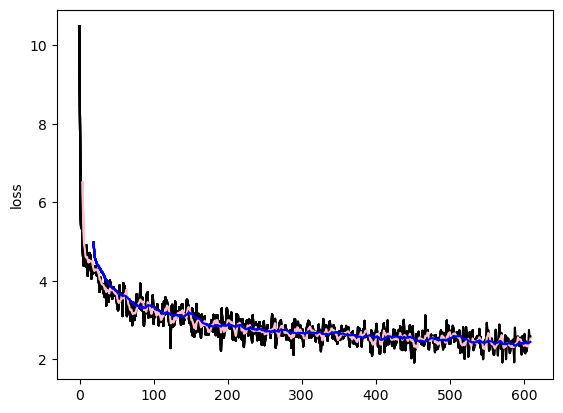

In [ ]:
model = Bert(VOCAB_SIZE, EMB_DIM, NUM_LAYERS, NUM_HEADS, FEED_FORWARD_DIM, MAX_SEQ_LEN, 0.1)

LM = BertLM(model, EMB_DIM, VOCAB_SIZE)
# LM = torch.load('saves/BERT_time: 10|04|2024 04:06:01|epoch: 5.pt')

trainer = BertTrainer(LM, vocab=vocab, device=DEVICE)
trainer.train(loader, 5)

<h1><strong>TESTING</strong></h1>

In [ ]:
text = "I am hungry and [MASK]."

In [ ]:
tokens = tokenizer.encode(text, return_tensors='pt')

In [ ]:
tokens

tensor([[   2,   50,  494, 3059,  122,    4,   17,    3]])

In [ ]:
pad = torch.zeros(MAX_SEQ_LEN - tokens[0].shape[0])

tokens = torch.cat((tokens[0], pad), 0).unsqueeze(0).int()

In [ ]:
preds = LM.forward(tokens.to(DEVICE))

In [ ]:
print(preds)

tensor([[[-3.9923e+01, -4.0692e+01, -1.0514e-04,  ..., -2.9400e+01,
          -2.8642e+01, -2.9934e+01],
         [-3.5518e+01, -3.5480e+01, -1.7187e+01,  ..., -2.6706e+01,
          -2.5938e+01, -2.7315e+01],
         [-3.0509e+01, -3.1062e+01, -1.6432e+01,  ..., -2.5195e+01,
          -2.2838e+01, -2.3752e+01],
         ...,
         [-1.6816e+01, -1.6769e+01, -1.0195e+01,  ..., -1.3205e+01,
          -1.3787e+01, -1.3083e+01],
         [-1.5995e+01, -1.5523e+01, -1.1847e+01,  ..., -1.2683e+01,
          -1.4017e+01, -1.2426e+01],
         [-1.7423e+01, -1.7385e+01, -9.9636e+00,  ..., -1.4167e+01,
          -1.4896e+01, -1.4073e+01]]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)


In [ ]:
pred_str = ""

for vals in tokens[0]:
    pred_str += vocab[vals.item()] + " "

print(pred_str)

[CLS] i am hungry and [MASK] . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 


In [ ]:
vocab = dict((v,k) for k,v in tokenizer.get_vocab().items())
pred_str = ""
for vals in preds[0]:
    pred_str += vocab[vals.argmax().item()] + " "

print(pred_str)

[CLS] i am hungry and sweet . [SEP] [SEP] [SEP] [SEP] happy scared happy scared scared . strong scared scared happy . scared scared alive hungry scared alive now . [SEP] . [SEP] [SEP] [SEP] [SEP] . happy [SEP] [SEP] scared . scared vulnerable . . . . . scared confused . [SEP] . ' [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] now now . alive . . happy exhausted not . happy . exhausted alive . . exhausted scared scared . confused scared . scared confused exhausted exhausted alive exhausted . scared scared scared scared scared . now alive [SEP] . not . . [SEP] . . . . scared happy happy . . [SEP] . . happy scared . happy [SEP] confused alive happy scared confused not 


In [ ]:
import datasets

glue_dataset = datasets.load_dataset("glue", "cola")

df = pd.DataFrame()
df['text'] = glue_dataset['train']['sentence']
ddf = dd.from_pandas(df, npartitions=1).compute()

print(ddf)

model = trainer
model.test_data = ddf

predictions = model.test(1)

glue_metric = datasets.load_metric("glue", "cola")
glue_score = glue_metric.compute(predictions=predictions, references=glue_dataset["labels"])

print(glue_score)

                                                   text
0     Our friends won't buy this analysis, let alone...
1     One more pseudo generalization and I'm giving up.
2      One more pseudo generalization or I'm giving up.
3        The more we study verbs, the crazier they get.
4             Day by day the facts are getting murkier.
...                                                 ...
8546                   Poseidon appears to own a dragon
8547                     Digitize is my happiest memory
8548                     It is easy to slay the Gorgon.
8549       I had the strangest feeling that I knew you.
8550                What all did you get for Christmas?

[8551 rows x 1 columns]


TypeError: BertTrainer.test() missing 2 required positional arguments: 'epoch' and 'tokenizer'